### This project is mainly divided into 5 segments. 
#### 1) Data preprocessing 
#### 2) Extracting food items logged by user & data analysis
#### 3) Analysis of user's most frequent meals (recent logged meal , users consuming similar food items, Login activity - ranked) 
#### 4) Analysis of breakfast , lunch and dinner timings
#### 5) Final data table 


### 1) Data preprocessing
####      1.a) Loading and sorting data

In [1]:
import pandas as pd
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
data = pd.read_json('data.json').sort_values('user_id')

#### 1.b) Cleaning data

In [3]:
def clean_text(text):
    
    text = text.lower()  # Lowercase the text
    
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    
    text = re.sub(r'\d+', '', text)  # Remove numbers using regular expression
    
    tokens = word_tokenize(text)  # Tokenizing the text
    
    stop_words = set(stopwords.words('english'))  # Removing the stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    cleaned_text = ' '.join(tokens)  # Joining the tokens back to text
    
    return cleaned_text

data['cleaned_description'] = data['description'].apply(clean_text)

#### 1.c) Lemmatization - reduce words to their root form

In [4]:
from nltk.stem import WordNetLemmatizer

# Lemmatization function
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

data['lemmatized_text'] = data['cleaned_description'].apply(lemmatize_text)

### 2) Extracting food items logged by user
#### 2.a) using "Dizex/InstaFoodRoBERTa-NER" Model from Hugging face

In [5]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline


tokenizer = AutoTokenizer.from_pretrained("Dizex/InstaFoodRoBERTa-NER") #loading tokenizer
model = AutoModelForTokenClassification.from_pretrained("Dizex/InstaFoodRoBERTa-NER") #loading model
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer) #pipeline for Named Entity Recognition

def extract_food_entities(text): #Function to extract food entities from a given text
  
    ner_results = ner_pipeline(text, aggregation_strategy="simple")   # Perform NER on the text
    
    def convert_entities_to_list(text, entities):  # Convert extracted entities to a list of strings
        ents = []
        for ent in entities:
            e = {"start": ent["start"], "end": ent["end"], "label": ent["entity_group"]}
            if ents and -1 <= ent["start"] - ents[-1]["end"] <= 1 and ents[-1]["label"] == e["label"]:
                ents[-1]["end"] = e["end"]
                continue
            ents.append(e)
        return [text[e["start"]:e["end"]] for e in ents]

    return convert_entities_to_list(text, ner_results)

data['extracted_food_entities'] = data['lemmatized_text'].apply(extract_food_entities)


#### 2.b) Deleting columns "cleaned_description" & "lemmatized_text"


In [6]:
columns_to_drop = ['lemmatized_text', 'cleaned_description']
data = data.drop(columns=columns_to_drop)

#### 2.c) Grouping all the food items logged by user


In [7]:
grouped = data.groupby('user_id')['extracted_food_entities'].agg(list)

def flatten_lists(user_list): #flattening the list
    return [item for sublist in user_list for item in sublist]

food_items_list = grouped.apply(flatten_lists)

user_data = food_items_list.reset_index(name='food_items_list')
user_data.head(3)

,user_id,food_items_list
0,U001,"[cocoa marshmallow, cinnamon, coffee, pork cho..."
1,U002,"[herbal tea, herbal tea, vegetable lasagna sid..."
2,U003,"[cocoa, mixed fruit, tea, tea, tea, cocoa, her..."


#### 2.d) Top 10 most consumed food items across all users

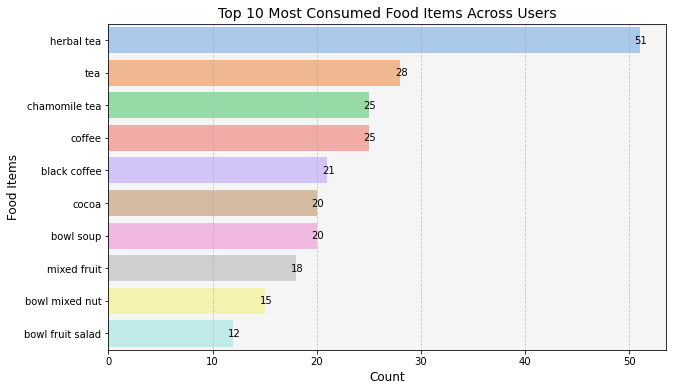

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

grouped = user_data.groupby('user_id')['food_items_list'].agg(list) # Group and flatten the data
food_items_list = grouped.apply(lambda x: [item for sublist in x for item in sublist])


all_food_items = [food for sublist in food_items_list for food in sublist] # Count occurrences of each food item
top_food_count = pd.Series(all_food_items).value_counts().head(10)


plt.figure(figsize=(10, 6)) # Plotting with Seaborn
sns.barplot(x=top_food_count.values, y=top_food_count.index, palette='pastel')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Food Items', fontsize=12)
plt.title('Top 10 Most Consumed Food Items Across Users', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f5f5f5')


for i, v in enumerate(top_food_count.values): # Adding data labels
    plt.text(v - 0.5, i, str(v), color='black', va='center')

plt.show()


#### 2.e) Removing Coffee/tea/Cocoa from food_items_list

In [9]:
def filter_items(food_list): #function to filter words 'coffee' 'tea' 'cocoa'
    return [item for item in food_list if 'coffee' not in item.lower() and 'tea' not in item.lower()and 'cocoa' not in item.lower()]

user_data['food_items'] = user_data['food_items_list'].apply(filter_items)

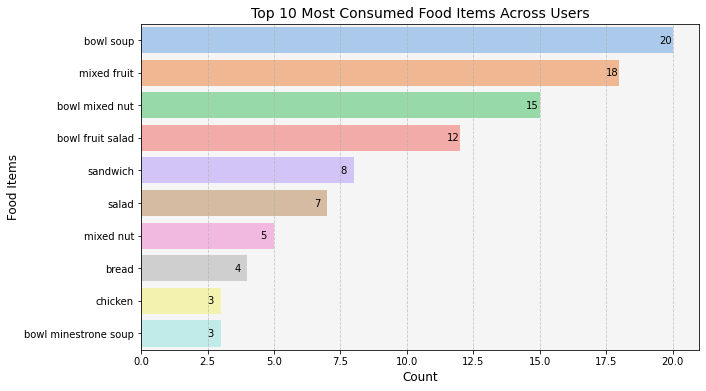

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

grouped = user_data.groupby('user_id')['food_items'].agg(list) # Group and flatten the data
food_items_list = grouped.apply(lambda x: [item for sublist in x for item in sublist])


all_food_items = [food for sublist in food_items_list for food in sublist] # Count occurrences of each food item
top_food_count = pd.Series(all_food_items).value_counts().head(10)


plt.figure(figsize=(10, 6)) # Plotting with Seaborn
sns.barplot(x=top_food_count.values, y=top_food_count.index, palette='pastel')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Food Items', fontsize=12)
plt.title('Top 10 Most Consumed Food Items Across Users', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f5f5f5')


for i, v in enumerate(top_food_count.values): # Adding data labels
    plt.text(v - 0.5, i, str(v), color='black', va='center')

plt.show()


### 3) Analysis of user's most frequent meals
#### 3.a) Function to extract top 3 frequently consumed food items - ranked

In [11]:
def top_3_food_items(food_list):
    count_series = pd.Series(food_list).value_counts()
    top_3 = count_series.nlargest(3).reset_index().rename(columns={'index': 'food_item', 0: 'count'})
    top_3['rank'] = top_3.index + 1  # Adding the 'rank' column
    return top_3[['rank', 'food_item']].values.tolist()

user_data['frequently consumed ranked'] = user_data['food_items'].apply(top_3_food_items)
del user_data['food_items'] # deleting column of food items without coffee,tea,cocoa

#### 3.b) Function to Fetch most recent meal & logged time

In [12]:
def find_most_recent_food_with_time_for_users(data):
    # Group data by user_id and find the most recent food and its time for each user
    grouped_data = data.sort_values('log_time', ascending=False).groupby('user_id').first().reset_index()
    
    # Rename columns for clarity
    grouped_data = grouped_data.rename(columns={'description': 'recent_meal', 'log_time': 'recent_meal_log_time'})
    
    return grouped_data[['user_id', 'recent_meal', 'recent_meal_log_time']]

recent_meal_with_time = find_most_recent_food_with_time_for_users(data)



In [13]:
user_data = pd.merge(user_data,recent_meal_with_time, on='user_id') #merging dataframe


#### 3.c) Activity ranking ( Most active user - rank 1 ) & Login count

In [14]:
login_count = data.groupby('user_id').size().reset_index(name='login_count') # Calculate the number of log-ins per user

# Sort users by the number of log-ins in descending order to get ranks
login_count['activity_rank'] = login_count['login_count'].rank(method='dense', ascending=False)

user_data = pd.merge(user_data,login_count, on='user_id') #merging dataframe
user_data.head(3)

,user_id,food_items_list,frequently consumed ranked,recent_meal,recent_meal_log_time,login_count,activity_rank
0,U001,"[cocoa marshmallow, cinnamon, coffee, pork cho...","[[1, bowl soup], [2, bowl mixed nut], [3, cinn...",A baguette with brie and grapes.,2020-12-28 07:40:00,63,8.0
1,U002,"[herbal tea, herbal tea, vegetable lasagna sid...","[[1, mixed fruit], [2, vegetable lasagna side ...",A slice of pepperoni pizza and a Caesar salad.,2020-12-22 12:00:00,73,4.0
2,U003,"[cocoa, mixed fruit, tea, tea, tea, cocoa, her...","[[1, mixed fruit], [2, salad], [3, bowl mixed ...",A hearty bowl of beef stew with carrots and po...,2020-12-26 17:50:00,95,1.0


#### 3.d) Discovering Users with Similar Food Preferences

In [15]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
 
food_lists = user_data['food_items_list'].tolist() #'food_items' column into a list of lists

mlb = MultiLabelBinarizer() # Initialize MultiLabelBinarizer

food_matrix = mlb.fit_transform(food_lists) # Fit_transform

# Create a DataFrame from the matrix, setting user_id as index
user_food_matrix = pd.DataFrame(food_matrix, columns=mlb.classes_, index=user_data['user_id'])


In [16]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(user_food_matrix) # Calculate cosine similarity between users

user_similarity_df = pd.DataFrame(user_similarity, index=user_food_matrix.index, columns=user_food_matrix.index) # Convert similarity matrix to DataFrame

# Find the most similar user for each user
most_similar_user = {}
for user in user_similarity_df.index:
    most_similar_user[user] = user_similarity_df[user].sort_values(ascending=False).index[1]


In [17]:
# Convert dictionary to DataFrame
similar_user_df = pd.DataFrame(list(most_similar_user.items()), columns=['user_id', 'Most_Similar_User'])

user_data = pd.merge(user_data,similar_user_df, on='user_id') #merging dataframe
user_data.head(3)

,user_id,food_items_list,frequently consumed ranked,recent_meal,recent_meal_log_time,login_count,activity_rank,Most_Similar_User
0,U001,"[cocoa marshmallow, cinnamon, coffee, pork cho...","[[1, bowl soup], [2, bowl mixed nut], [3, cinn...",A baguette with brie and grapes.,2020-12-28 07:40:00,63,8.0,U003
1,U002,"[herbal tea, herbal tea, vegetable lasagna sid...","[[1, mixed fruit], [2, vegetable lasagna side ...",A slice of pepperoni pizza and a Caesar salad.,2020-12-22 12:00:00,73,4.0,U008
2,U003,"[cocoa, mixed fruit, tea, tea, tea, cocoa, her...","[[1, mixed fruit], [2, salad], [3, bowl mixed ...",A hearty bowl of beef stew with carrots and po...,2020-12-26 17:50:00,95,1.0,U009


In [18]:
user_data_1 = user_data

### 4) Analysis of breakfast, lunch and dinner timings
#### 4.a) Removing rows containing only "coffee", "tea", "cocoa"  from dataset. 

In [19]:
import re

def filter_food_items(row):
    coffee_tea_cocoa = ['coffee', 'tea', 'cocoa']
    # Convert the food items to lowercase 
    food_items = [item.lower() for item in row['extracted_food_entities']]
    
    # Regular expression pattern to match standalone occurrences of unwanted words
    unwanted_pattern = r'\b(?:' + '|'.join(coffee_tea_cocoa) + r')\b'  # Matches coffee, tea, cocoa
    
    # Compile the pattern for efficiency
    pattern = re.compile(unwanted_pattern)
    
    # Check for standalone occurrences of unwanted words in the food items
    if any(re.search(pattern, item) for item in food_items):
        return False  # Remove the row if standalone occurrences are found
    
    return True


In [20]:
filtered_data = data[data.apply(filter_food_items, axis=1)].copy()



#### 4.b) Subjective classification of breakfast, Lunch, Dinner timings and objectively classifying the same timings for individual users using statistical-mode technique

In [21]:
# Subjectively classify meal times
breakfast_hours = [6, 7, 8, 9, 10, 11]
lunch_hours = [12, 13, 14, 15, 16, 17]
dinner_hours = [18, 19, 20, 21, 22, 23, 24]


def get_meal_timings(user_data):
    user_data['log_time'] = pd.to_datetime(user_data['log_time'])
    user_data['hour'] = user_data['log_time'].dt.hour

    breakfast_data = user_data[user_data['hour'].isin(breakfast_hours)]
    lunch_data = user_data[user_data['hour'].isin(lunch_hours)]
    dinner_data = user_data[user_data['hour'].isin(dinner_hours)]

    # Count occurrences outside mealtime ranges
    outside_meal_ranges = user_data[
        (~user_data['hour'].isin(breakfast_hours)) &
        (~user_data['hour'].isin(lunch_hours)) &
        (~user_data['hour'].isin(dinner_hours))
    ]

    if (
        not breakfast_data.empty
        and not lunch_data.empty
        and not dinner_data.empty
    ):
        breakfast_peak = breakfast_data['hour'].mode().values[0]
        lunch_peak = lunch_data['hour'].mode().values[0]
        dinner_peak = dinner_data['hour'].mode().values[0]

        breakfast_range = f"{breakfast_peak - 1}-{breakfast_peak + 1}"
        lunch_range = f"{lunch_peak - 1}-{lunch_peak + 1}"
        dinner_range = f"{dinner_peak - 1}-{dinner_peak + 1}"

        return pd.DataFrame({
            'user_id': [user_data['user_id'].iloc[0]],
            'breakfast_peak': [breakfast_peak],
            'lunch_peak': [lunch_peak],
            'dinner_peak': [dinner_peak],
            'breakfast_range': [breakfast_range],
            'lunch_range': [lunch_range],
            'dinner_range': [dinner_range],
            'meals_outside_ranges': [outside_meal_ranges.shape[0]]  # Count of meals outside ranges
        })
    else:
        return pd.DataFrame()

user_meal_timings_df = pd.DataFrame(columns=['user_id', 'breakfast_peak', 'lunch_peak', 'dinner_peak',
                                             'breakfast_range', 'lunch_range', 'dinner_range',
                                             'meals_outside_ranges'])

for user_id in filtered_data['user_id'].unique():
    user_data = filtered_data[filtered_data['user_id'] == user_id].copy()
    meal_timings = get_meal_timings(user_data)
    if not meal_timings.empty:
        user_meal_timings_df = user_meal_timings_df.append(meal_timings, ignore_index=True)


In [22]:
 user_meal_timings_df

,user_id,breakfast_peak,lunch_peak,dinner_peak,breakfast_range,lunch_range,dinner_range,meals_outside_ranges
0,U001,7,13,19,6-8,12-14,18-20,9
1,U002,10,16,22,9-11,15-17,21-23,7
2,U003,9,14,19,8-10,13-15,18-20,12
3,U004,8,12,19,7-9,11-13,18-20,9
4,U005,10,17,18,9-11,16-18,17-19,7
5,U006,9,16,19,8-10,15-17,18-20,10
6,U007,8,12,21,7-9,11-13,20-22,12
7,U008,9,12,21,8-10,11-13,20-22,6
8,U009,7,14,20,6-8,13-15,19-21,12
9,U010,11,16,20,10-12,15-17,19-21,9


In [23]:
#renaming columns
user_meal_timings_df = user_meal_timings_df.rename(columns={
    'user_id': 'user_id',
    'breakfast_peak': 'Usual Breakfast Time',
    'lunch_peak': 'Usual Lunch Time',
    'dinner_peak': 'Usual Dinner Time',
    'breakfast_range': 'Breakfast Time Range',
    'lunch_range': 'Lunch Time Range',
    'dinner_range': 'Dinner Time Range',
    'meals_outside_ranges': 'Meals Outside Usual Ranges'
})


In [24]:
 user_data_2 = user_meal_timings_df

### 5) Final table containing user meal log metrics

In [25]:
user_data = pd.merge( user_data_1,  user_data_2, on='user_id')

In [26]:
user_data

,user_id,food_items_list,frequently consumed ranked,recent_meal,recent_meal_log_time,login_count,activity_rank,Most_Similar_User,Usual Breakfast Time,Usual Lunch Time,Usual Dinner Time,Breakfast Time Range,Lunch Time Range,Dinner Time Range,Meals Outside Usual Ranges
0,U001,"[cocoa marshmallow, cinnamon, coffee, pork cho...","[[1, bowl soup], [2, bowl mixed nut], [3, cinn...",A baguette with brie and grapes.,2020-12-28 07:40:00,63,8.0,U003,7,13,19,6-8,12-14,18-20,9
1,U002,"[herbal tea, herbal tea, vegetable lasagna sid...","[[1, mixed fruit], [2, vegetable lasagna side ...",A slice of pepperoni pizza and a Caesar salad.,2020-12-22 12:00:00,73,4.0,U008,10,16,22,9-11,15-17,21-23,7
2,U003,"[cocoa, mixed fruit, tea, tea, tea, cocoa, her...","[[1, mixed fruit], [2, salad], [3, bowl mixed ...",A hearty bowl of beef stew with carrots and po...,2020-12-26 17:50:00,95,1.0,U009,9,14,19,8-10,13-15,18-20,12
3,U004,"[herbal tea, orange juice, tea, bowl fruit sal...","[[1, bowl fruit salad], [2, sandwich], [3, mix...",A slice of apple pie with vanilla ice cream.,2020-12-19 13:35:00,67,6.0,U009,8,12,19,7-9,11-13,18-20,9
4,U005,"[caesar salad, chicken crouton, parfait layer ...","[[1, chicken], [2, bowl soup], [3, bowl mixed ...",A cup of chai tea and a slice of carrot cake.,2020-12-29 19:05:00,64,7.0,U009,10,17,18,9-11,16-18,17-19,7
5,U006,"[chicken tikka masala basmati rice, mixed frui...","[[1, bowl soup], [2, mixed nut], [3, bowl mixe...",A bowl of ramen with pork and nori.,2020-12-30 15:30:00,75,3.0,U008,9,16,19,8-10,15-17,18-20,10
6,U007,"[chamomile tea, cocoa, sandwich turkey avocado...","[[1, bowl soup], [2, mixed fruit], [3, bowl mi...",A plate and fork set on a living room coffee t...,2020-12-15 21:30:00,78,2.0,U004,8,12,21,7-9,11-13,20-22,12
7,U008,"[belgian waffle nutella, banana, vegetable sti...","[[1, bowl soup], [2, belgian waffle nutella], ...",A stack of pancakes with maple syrup.,2020-12-31 10:45:00,69,5.0,U009,9,12,21,8-10,11-13,20-22,6
8,U009,"[chamomile tea, smoothie bowl pineapple mango ...","[[1, salad], [2, bowl mixed nut], [3, bowl soup]]",A plate and fork set on a living room coffee t...,2020-12-16 03:00:00,67,6.0,U003,7,14,20,6-8,13-15,19-21,12
9,U010,"[bowl pumpkin soup, pumpkin seed, chamomile te...","[[1, bowl mixed nut], [2, bowl fruit salad], [...",A plate and fork set on a living room coffee t...,2020-12-16 00:00:00,73,4.0,U009,11,16,20,10-12,15-17,19-21,9
